In [182]:
import numpy
import random
import math
from scipy.optimize import minimize
import matplotlib.pyplot as plt

### Generating Test Data

In [183]:
numpy.random.seed(100) #get the same random data

classA = numpy.concatenate(
    (numpy.random.randn(10,2) * 0.3 + [1.5,0.5],
    numpy.random.randn(10,2) * 0.3 + [-1.5,0.5]))
classB = numpy.random.randn(20,2) * 0.3 + [0.0, -0.5]

inputs = numpy.concatenate((classA, classB)) 
targets = numpy.concatenate(
    (numpy.ones(classA.shape[0]),
    -numpy.ones(classB.shape[0]))) 

N = inputs.shape[0] #Number of rows (samples)

permute = list(range(N))
random.shuffle(permute)
inputs = inputs[permute,:] #a Nx2 array, where each row contains the (x,y)-coordinates of a datapoint
targets = targets[permute] #a Nx1 array which contains the classes, i.e. the ti values, encoded as (-1 or 1)

In [184]:
print(N)

40


In [185]:
print(inputs)

[[-1.90691971  0.13026965]
 [ 1.70181624  0.46867666]
 [ 0.225136   -0.8920977 ]
 [-0.35640528 -0.66492386]
 [-1.27486657  0.36321592]
 [ 0.97507036  0.60280412]
 [ 0.07135339 -0.49593544]
 [-0.29499303 -0.39274767]
 [ 0.03265904 -0.34765712]
 [-1.59787142  0.5167028 ]
 [ 1.44315125  0.57650043]
 [-0.02388337 -0.76691944]
 [ 1.32492148  0.74505412]
 [-1.2806999   0.90846684]
 [-0.26453952 -0.49440832]
 [-1.44464439  0.78112466]
 [ 1.36855931  0.16450453]
 [-0.55235649 -0.39017203]
 [ 1.79439624  0.65426565]
 [ 0.174172   -0.83135693]
 [-0.48407355 -0.05878584]
 [ 0.61038227 -0.66521432]
 [ 1.5663539   0.178987  ]
 [-1.14311332 -0.00718505]
 [ 0.18391166 -0.27913844]
 [ 0.00219437 -0.68388162]
 [-0.28201385 -0.74837971]
 [-0.16333175 -0.70045152]
 [ 1.34061589  0.80891981]
 [-0.09953314 -0.70676539]
 [-1.57556374  0.24726928]
 [-0.49065882 -0.81326296]
 [ 0.38992442 -1.01992869]
 [-1.72690569  0.7449362 ]
 [ 1.3625919   0.63054905]
 [ 0.30807643 -0.92965718]
 [ 1.84591074  0.42426919]
 

In [186]:
print(targets)

[ 1.  1. -1. -1.  1.  1. -1. -1. -1.  1.  1. -1.  1.  1. -1.  1.  1. -1.
  1. -1. -1. -1.  1.  1. -1. -1. -1. -1.  1. -1.  1. -1. -1.  1.  1. -1.
  1. -1.  1.  1.]


### Things to implement

#### · A suitable kernel function

In [187]:
def linear_kernel(xi,xj):
    """
    kernel function using the linear kernel.
    
    arguments: two data points, xi and xj, in forms of 1x2 array, e.g. xi=array([a b]).
    return: scalar product, K, between xi and xj.
    """
    
    K = numpy.dot(xi,xj)
    return K

In [188]:
def poly_kernel(xi,xj,p):
    """
    kernel function using polynomial kernel.
    
    arguments: two data points, xi and xj, in forms of 1x2 array, e.g. xi=array([a b]).
                p, positive integer, degree of polynomials.
    return: scalar product, K, between xi and xj.
    """
    
    K = numpy.power((numpy.dot(xi,xj) + 1), p)
    return K

In [189]:
def RBF_kernel(xi,xj,sigma):
    """
    kernel function using RBF kernel.
    
    arguments: two data points, xi and xj, in forms of 1x2 array, e.g. xi=array([a b]).
                sigma, smoothness of the boundary.
    return: scalar product, K, between xi and xj.
    """
    
    norm = numpy.linalg.norm(numpy.subtract(xi,xj))
    num = numpy.power(norm, 2)
    den = 2 * numpy.power(sigma, 2)
    
    K = numpy.power(numpy.e, (-num/den))
    return K

#### · Implement the function objective

In [190]:
def pre_compute(inputs=inputs, targets=targets):
    """
    pre-compute NxN matrix P, where P_ij = ti*tj*Kernel(xi,xj).
    
    arguments: data points 'inputs', classification result 'targets'.
    return: P matrix.
    """

    P = numpy.zeros((N,N))

    for i in range(N):
        for j in range(N):
            P[i][j] = targets[i]*targets[j]*linear_kernel(inputs[i], inputs[j])
    return P

In [191]:
#initialize alpha as a vector of zeros
start = numpy.zeros(N)
print(start)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [192]:
def objective(alpha):
    """
    dual formulation, transformed from the optimization problem.
    
    arguments: alpha, 1xN vector.
    return: a scalar value, obj.
    """
    
    P = pre_compute()
    
    #alphaT = alpha.reshape(alpha.shape[0],1) #transpose alpha to Nx1 array
    #A = numpy.dot(alphaT, numpy.transpose(alphaT)) #A_ij = alpha_i * alpha_j
    #print(A)
    
    obj = 0.5 * numpy.dot(alpha, numpy.dot(alpha,P)) - numpy.sum(alpha)
    return obj

#### · implement the function zerofun

In [193]:
def zerofun(alpha, targets=targets):
    """
    the equality constraint, sum(i)(alpha_i * ti) = 0.
    
    arguments: alpha, 1xN vector.
    return: a scalar value,zf = sum(i)(alpha_i * ti).
    """
    
    zf = numpy.dot(alpha,targets)
    return zf

#### · call minimize

In [194]:
C = 100 #choose arbitrary upper bound C for slack variables
B = [(0, C) for b in range(N)]

XC = {'type':'eq', 'fun':zerofun}

ret = minimize(objective, start, bounds=B, constraints=XC)
alpha = ret['x']

In [195]:
print(alpha)

[0.00000000e+00 1.80708342e-13 0.00000000e+00 0.00000000e+00
 2.34254284e-13 0.00000000e+00 3.38714548e-13 1.61452098e-12
 2.13832783e-12 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.44217376e-13 0.00000000e+00
 2.90838592e+01 1.66797267e-12 3.03332126e-14 0.00000000e+00
 1.00000000e+02 0.00000000e+00 0.00000000e+00 7.98612078e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.52433924e-12 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 5.17743015e-13 8.94506701e+00 0.00000000e+00 0.00000000e+00]


#### · Extract the non-zero alpha values

In [196]:
def extract(alpha=alpha):
    """
    extract the non-zero alpha values.
    
    arguments: list of alpha vluaes, alpha.
    return: list of non-zero alpha, x datapoints corresponding to non-zero alpha, targets corresponding to non-zero alpha.
    """
    
    #nzalpha = [] #list of non-zero alpha
    #nzinputs = [] #list of x datapoints corresponding to non-zero alpha
    #nztargets = [] #list of targets corresponding to non-zero alpha
    nzlist = []
    
    for i in range(N):
        if abs(alpha[i])>1e-05:
            #nzalpha.append(alpha[i])
            #nzinputs.append(inputs[i])
            #nztargets.append(targets[i])
            nzlist.append([alpha[i], inputs[i], targets[i]])
        
    #nzlist = [nzalpha, nzinputs, nztargets]  
    return nzlist

In [197]:
extract()

[[29.083859187113354, array([1.36855931, 0.16450453]), 1.0],
 [100.0, array([-0.48407355, -0.05878584]), -1.0],
 [79.86120781878607, array([-1.14311332, -0.00718505]), 1.0],
 [8.945067005806253, array([-0.2586682 , -0.12515908]), -1.0]]

#### · Calculate threshold value, b

In [198]:
def bvalue(sv, tsv, nzlist=extract()):
    """
    calculate threshold value for any supporting vector, sv.
    
    arguments: sv, any supporting vector. sv=extract()[i][1]
                tsv, target of the supporitng vector. tsv=extract()[i][2]
                nzlist = list of [alpha[i], inputs[i], targets[i]]
    return: b value.
    """
    
    b = 0
    
    for i in range(len(nzlist)):
        b += nzlist[i][0] * nzlist[i][2] * linear_kernel(sv, nzlist[i][1])
        
    b = b - tsv
    return b

In [199]:
sv=extract()[0][1]
tsv=extract()[0][2]
bvalue(sv, tsv)

-0.20478666111911092

#### · Implement the indicator function

In [200]:
def indicator(x, y, sv=extract()[0][1], tsv=extract()[0][2], nzlist=extract()):
    """
    the indicator function.
    
    arguments: sv, supporting vector point. tsv, target value of supporting vector. 
                nzlist = list of [alpha[i], inputs[i], targets[i]]
    return: indicate value of supporting vector s.
    """
    
    ind = 0
    
    for i in range(len(nzlist[0])):
        ind += nzlist[i][0] * nzlist[i][2] * linear_kernel([x,y], nzlist[i][1])
    
    ind = ind - bvalue(sv, tsv)
    return ind

### Plotting

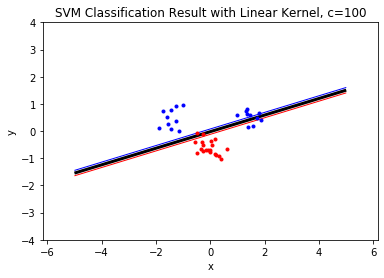

In [201]:
#plot data points
plt.plot([p[0] for p in classA],
         [p[1] for p in classA],
         'b.')
plt.plot([p[0] for p in classB],
         [p[1] for p in classB],
         'r.')

#contour plot
xgrid=numpy.linspace(-5, 5)
ygrid=numpy.linspace(-4, 4)

grid=numpy.array([[indicator(x, y)
                  for x in xgrid]
                 for y in ygrid])

plt.contour(xgrid, ygrid, grid,
           (-1.0, 0.0, 1.0),
           colors=('red', 'black', 'blue'),
           linewidths=(1, 3, 1))

plt.xlabel('x')
plt.ylabel('y')
plt.title('SVM Classification Result with Linear Kernel, c=100')

plt.axis('equal') #force same scale on both axes
plt.savefig('svmplot5-2.png') #save a copy in a file
plt.show() #show the plot on the screen